<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Literature-Review" data-toc-modified-id="Literature-Review-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Literature Review</a></span></li><li><span><a href="#SchNet-Implementation" data-toc-modified-id="SchNet-Implementation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>SchNet Implementation</a></span><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#SchNet-model" data-toc-modified-id="SchNet-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SchNet model</a></span><ul class="toc-item"><li><span><a href="#Distance-expansion" data-toc-modified-id="Distance-expansion-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Distance expansion</a></span></li><li><span><a href="#Continuous-filter-convolutional-layer" data-toc-modified-id="Continuous-filter-convolutional-layer-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Continuous-filter convolutional layer</a></span></li><li><span><a href="#Interaction-block" data-toc-modified-id="Interaction-block-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Interaction block</a></span></li><li><span><a href="#SchNet-Model" data-toc-modified-id="SchNet-Model-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>SchNet Model</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Invariance-to-permutation" data-toc-modified-id="Invariance-to-permutation-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Invariance to permutation</a></span><ul class="toc-item"><li><span><a href="#Mathematical-analysis" data-toc-modified-id="Mathematical-analysis-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Mathematical analysis</a></span></li><li><span><a href="#Experimental-verification" data-toc-modified-id="Experimental-verification-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Experimental verification</a></span></li></ul></li><li><span><a href="#Invariance-to-rotation" data-toc-modified-id="Invariance-to-rotation-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Invariance to rotation</a></span><ul class="toc-item"><li><span><a href="#Mathematical-analysis" data-toc-modified-id="Mathematical-analysis-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Mathematical analysis</a></span></li><li><span><a href="#Experimental-verification" data-toc-modified-id="Experimental-verification-2.5.2"><span class="toc-item-num">2.5.2&nbsp;&nbsp;</span>Experimental verification</a></span></li></ul></li><li><span><a href="#Main-function" data-toc-modified-id="Main-function-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Main function</a></span></li></ul></li><li><span><a href="#Improvement" data-toc-modified-id="Improvement-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Improvement</a></span><ul class="toc-item"><li><span><a href="#Weighted-Filter" data-toc-modified-id="Weighted-Filter-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Weighted Filter</a></span></li><li><span><a href="#Data-Sphering" data-toc-modified-id="Data-Sphering-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data Sphering</a></span></li></ul></li></ul></div>

# Literature Review

**[SchNet: A continuous-filter convolutional neural network for modeling quantum interactions](https://arxiv.org/abs/1706.08566)**



# SchNet Implementation

- Dataset: QM9
- Benchmarks: U0 (Internal energy at 0K)

In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from math import pi as PI
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_add_pool, radius_graph, MessagePassing


def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed(0)

## Data preparation

> **Key steps:**
> 
> - Download data and set target;
> - Use ```atomref``` to correct the energy of intramolecular interactions;
> - Transform the unit from eV to kcal/mol to be consistent with the paper;
> - Normalize the data to improve model generalization;
> - Split training and test set, use ```50000``` samples for training, ```1000``` for test.

In [2]:
def load_data():
    dataset = QM9(root='./qm9')

    target = 7
    KCALMOL2EV = 0.04336414
    num_train = 50000
    num_test = 1000

    atomref = dataset.atomref(target)
    for index, data in enumerate(dataset):
        dataset[index].y[:, target] = data.y[:, target] - atomref[data.z].sum()

    dataset.y = dataset.y // KCALMOL2EV

    mean = dataset.y.mean(dim=0, keepdim=True)
    std = dataset.y.std(dim=0, keepdim=True)
    dataset.y = (dataset.y - mean) / std
    mean, std = mean[:, target].item(), std[:, target].item()
    print(f"mean and std values of U0: mean = {mean}, std = {std}")

    train_dataset = dataset[:num_train]
    test_dataset = dataset[num_train:num_train + num_test]
    train_loader = DataLoader(train_dataset,
                              batch_size=64,
                              shuffle=True,
                              drop_last=True)
    test_loader = DataLoader(test_dataset,
                             batch_size=64,
                             shuffle=False,
                             drop_last=True)
    return train_loader, test_loader, mean, std

## SchNet model


![SchNet Structure](./assets/SchNet.png)

Hyperparameters:
```python
hidden_channels: 64    # The hidden embedding size
num_interactions = 3   # The number of interaction blocks
num_filters = 64       # The number of filters used in the cfconv layer
num_gaussians = 300    # The number of gaussians used in RBF
cutoff = 30            # The cutoff value for RBF-based distance expansion
```


### Distance expansion

Expand the atomic distance with Gaussian Radial Basis Functions (RBF)  to describe the atomic interactions in the molecule: 

$$e_k(\mathbf{r}_i-\mathbf{r}_j)=\text{exp}(-\gamma \Vert d_{ij}-\mu_k \Vert ^2), \text{where } d_{ij}=\Vert \mathbf{r}_i-\mathbf{r}_j \Vert.$$

In the paper, $0<\mu_k<30$, and $\mu_{k+1}-\mu{k}=0.1$. Therefore, we set the ```cutoff = 30``` and ```num_guassians = 300``` here.

In [3]:
class GaussianSmearing(torch.nn.Module):

    def __init__(
        self,
        cutoff: float = 30.0,
        num_gaussians: int = 300,
    ):
        super().__init__()
        offset = torch.linspace(0.0, cutoff, num_gaussians)
        self.coeff = -10
        self.register_buffer('offset', offset)

    def forward(self, dist: Tensor) -> Tensor:  # dist = d_{ij} range: 0-7
        dist = dist.view(-1, 1) - self.offset.view(1, -1)
        return torch.exp(self.coeff * torch.pow(dist, 2))

### Continuous-filter convolutional layer 

$$W^l: \mathbb{R}^D \rightarrow \mathbb{R}^F$$

$$\mathbf{x}_i^{l+1}=\left(X^l * W^l\right)_i=\sum_j \mathbf{x}_j^l \circ W^l\left(\mathbf{r}_i-\mathbf{r}_j\right)$$

In the paper, the variable $W$ is obtained using an MLP neural network with two fully-connected layers followed with activation function, and the same approach is used here. The ```edge_attr``` is generated with the RBF. And the propagation includes message passing, aggregation, and updating processes. Since the ```aggregate``` and ```update``` functions remains the same as the inherited class, I only re-write the message function according to the cfconv equations.

In [4]:
class CFConv(MessagePassing):

    def __init__(self, nn_layers: nn.Sequential):
        super().__init__(aggr='add')
        self.nn = nn_layers

    def forward(self, h, edge_index, edge_weight, edge_attr):
        W = self.nn(edge_attr)
        x = self.propagate(edge_index, x=h,W=W)  # message -> aggregate -> update
        return x

    def message(self, x_j: Tensor, W: Tensor) -> Tensor:
        return x_j * W

### Interaction block

The interaction block includes an atom-wise layer, a cfconv layer, and an MLP, responsible for updating the atomic representations based on the molecular geometry.

In [5]:
class Interaction(nn.Module):

    def __init__(self, hidden_channels: int, num_gaussians: int,
                 num_filters: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_gaussians, hidden_channels),
            ShiftedSoftplus(),
            nn.Linear(hidden_channels, num_filters),
            ShiftedSoftplus(),
        )
        self.atom_wise = nn.Linear(hidden_channels, hidden_channels)
        self.conv = CFConv(self.mlp)
        self.out = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            ShiftedSoftplus(),
            nn.Linear(hidden_channels, hidden_channels),
        )

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.atom_wise.weight)
        self.atom_wise.bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.mlp[0].weight)
        self.mlp[0].bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.mlp[2].weight)
        self.mlp[2].bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.out[0].weight)
        self.out[0].bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.out[2].weight)
        self.out[2].bias.data.fill_(0)

    def forward(self, h, edge_index, edge_weight, edge_attr):
        h = self.atom_wise(h)
        h = self.conv(h, edge_index, edge_weight, edge_attr)
        h = self.out(h)
        return h

### SchNet Model

SchNet is composed of an embedding layer, several interaction layers (3 in the paper), one atom-wise layer followed with activation function and one atom-wise layer followed with sum pooling layer. Here the number of hidden channels is set to 64 as the paper.

In [6]:
class SchNetModel(nn.Module):

    def __init__(self):
        super(SchNetModel, self).__init__()

        self.hidden_channels = 64
        self.num_interactions = 3
        self.num_filters = 64
        self.num_gaussians = 300
        self.cutoff = 10.0

        self.embedding = nn.Embedding(100, self.hidden_channels, padding_idx=0)
        self.interactions = nn.ModuleList()
        for _ in range(self.num_interactions):
            block = Interaction(self.hidden_channels, self.num_gaussians,
                                self.num_filters)
            self.interactions.append(block)
        self.layers = nn.Sequential(
            nn.Linear(self.hidden_channels, self.hidden_channels // 2),
            ShiftedSoftplus(), nn.Linear(self.hidden_channels // 2, 1))
        self.distance_expansion = GaussianSmearing(self.cutoff,
                                                   self.num_gaussians)

        self.reset_parameters()

    def reset_parameters(self):
        self.embedding.reset_parameters()
        for interaction in self.interactions:
            interaction.reset_parameters()
        torch.nn.init.xavier_uniform_(self.layers[0].weight)
        self.layers[0].bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.layers[2].weight)
        self.layers[2].bias.data.fill_(0)

    def forward(self, data):
        pos, z, batch = data.pos, data.z, data.batch
        pos.require_grad = True

        edge_index = radius_graph(pos, r=self.cutoff, batch=batch)
        row, col = edge_index
        edge_weight = (pos[row] - pos[col]).norm(dim=-1)
        edge_attr = self.distance_expansion(edge_weight)

        x_emb = self.embedding(z)
        h = x_emb
        for interaction in self.interactions:
            h = h + interaction(h, edge_index, edge_weight, edge_attr)
        h = self.layers(h)
        
        out = global_add_pool(h, batch)
        return out


class ShiftedSoftplus(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.shift = torch.log(torch.tensor(2.0)).item()

    def forward(self, x: Tensor) -> Tensor:
        return F.softplus(x) - self.shift

In [7]:
def train(model, train_loader, test_loader, optimizer, scheduler, epochs, mean, std, device, model_path, pretrained = False):    
    global_step = 0

    if not pretrained:
        for epoch in range(epochs):
            total_loss = 0
            total_mae = 0
            model.train()
            for data in train_loader:
                data.to(device)
                optimizer.zero_grad()
                out = model(data)
                target = data.y[:, 7].unsqueeze(1)

                loss = F.mse_loss(
                    out, target)  # Using the 7th property U0 as the target
                loss.backward()
                optimizer.step()

                out = out * std + mean
                target = target * std + mean
                mae = torch.sum(torch.abs(target - out)) // len(target)
                total_loss += loss.item()
                total_mae += mae.item()
                global_step += 1

                if global_step % 10000 == 0:
                    scheduler.step()

            mse = total_loss / len(train_loader)
            mae = total_mae / len(train_loader)
            print(
                f"Training {epoch} Loss = {loss:.6f}, MAE = {mae:.6f}, LR = {scheduler.get_last_lr().item()}"
            )

            # Evaluate
            loss, test_mae = evaluate_model(model, epoch, test_loader, device,
                                            mean, std)
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1} Model Saving ...")
                torch.save(model.state_dict(),
                           f"schnet_energy_model_{epoch+1}.pth")
    else:
        model = SchNetModel()
        model.load_state_dict(torch.load(model_path))

## Evaluation

Report loss and Mean Absolute Error (MAE) after each epoch, where the loss is calculated with normalized target and the mae is calculated with the real U0 values restored using ```mean``` and ```std``` in data preparation. 

In [8]:
def evaluate_model(model, epoch, loader, device, mean, std):
    model.eval()
    total_loss = 0
    total_mae = 0
    for data in loader:
        data.to(device)
        with torch.no_grad():
            out = model(data)
            target = data.y[:, 7].unsqueeze(1)
            loss = F.mse_loss(out, target)

            out = out * std + mean
            target = target * std + mean
            mae = torch.sum(torch.abs(target - out)) // len(target)

            total_loss += loss.item()
            total_mae += mae.item()
    loss = total_loss / len(loader)
    mae = total_mae / len(loader)
    print(f"Validation Epoch {epoch+1} Loss = {loss:.6f}, MAE = {mae:.6f}")
    return loss, mae

## Invariance to permutation

### Mathematical analysis

Permutation invariance means that the output of the network does not change if the order of the input atoms is changed. In SchNet, permutation invariance is achieved through its use of **continuous-filter convolutional layers** and the way it handles atomic features.Other layers such as **dense layers** and **atom-wise layers** do not inherently contribute to this symmetry property because they do not handle atomic interactions.

- In SchNet, a molecule in a certain conformation can be described uniquely by a set of $n$ atoms with nuclear charges $\mathbf{Z}=(\mathbf{Z}_1, ...,\mathbf{Z}_n)$ and atomic positions $\mathbf{R}=(\mathbf{r}_1, ...,\mathbf{r}_n)$. To obtain a standard graph $\mathbf{G}$ with a set of nodes $\mathbf{V}$ and edges $\mathbf{E}$, $\mathbf{Z}$ is embedded into $\mathbf{V} \in \mathbb{R}^F$, where $F$ is the dimension of hidden features. Adjancency matrix $\mathbf{E}$ is generated by connecting every atom to every atom, which makes it invariant to atom order and $\mathbf{G}$ a complete graph. Consider a permutation $\sigma$ on the atom order, we have:

$$\mathbf{E}(\mathbf{V}_1, ...,\mathbf{V}_n) = \mathbf{E}(\mathbf{V}_{\sigma(1)}, ...,\mathbf{V}_{\sigma(n)}) = \begin{bmatrix}
 0 & 1 & ... & 1\\
 1 & 0 & ... & 1\\
 \vdots & \vdots &\ddots &\vdots \\
 1 & 1 & ... & 0 \\
\end{bmatrix} $$

- Moreover, in SchNet, features of atoms are updated based on interactions with neighboring atoms. These interactions are aggregated using a sum over neighbors, which is a permutation-invariant operation. Consider a set of atom features ${\mathbf{h}_1,...,\mathbf{h}_n}$ and a permutation $\sigma$ of these features ${\mathbf{h}_{\sigma(1)},...,\mathbf{h}_{\sigma(n)}}$. The update of an atom's feature in SchNet depends on the sum of features of neighboring atoms. If we permute the atoms, the summation operation in the aggregation phase remains unchanged because summing is invariant to the order of its operands:

$$\text{sum}(\mathbf{h}_1,...,\mathbf{h}_n)=\text{sum}(\mathbf{h}_{\sigma(1)},...,\mathbf{h}_{\sigma(n)}) $$

- Another reason for SchNet to be invariant to permutations is that SchNet generates filters dynamically based on the distances between atoms. These filters are used to modulate the influence of neighboring atoms' features based on their relative distances $\Vert \mathbf{r}_i - \mathbf{r}_j \Vert$. Since the generation and application of these filters are solely based on distances (which are permutation invariant), the output of the convolutional layers remains invariant to permutations of the input atoms. 

Conclusively, the primary reasons why SchNet is invariant to permutations include: 1. Invariant adjacency matrix; 2. Aggregation mechanism; 3. Distance-based filter generation.


### Experimental verification

In [9]:
def verify_permutation_invariance(model, data):
    permuted_data = data.clone()
    node_permutation = torch.randperm(data.num_nodes)
    permuted_data.x = data.x[node_permutation]
    if data.edge_index is not None:
        edge_index_remap = {
            i: node_permutation[i].item()
            for i in range(data.num_nodes)
        }
        permuted_data.edge_index = torch.tensor(
            [[edge_index_remap[i.item()] for i in row]
             for row in data.edge_index.t()]).t()

    return torch.allclose(model(data), model(permuted_data))

## Invariance to rotation

### Mathematical analysis

Rotation invariance means the model's output remains unchanged under rotations of the input molecular structure. The key point for SchNet to be rotation-invariant is the usage of interatomic distances $\Vert \mathbf{r}_i - \mathbf{r}_j \Vert$ as part of its input features.

Let $\mathbf{R}$ be a rotation matrix, and consider the position vectors $\mathbf{r}_i$ and $\mathbf{r}_j$ of two atoms. Under rotation, their positions change to $\mathbf{Rr}_i$ and $\mathbf{Rr}_j$. The distance between these atoms is:

$$\Vert \mathbf{Rr}_i - \mathbf{Rr}_j \Vert = \Vert \mathbf{R}(\mathbf{r}_i - \mathbf{r}_j) \Vert$$

Since rotation matrices preserve distances (norms), the above expression simplifies to:

$$\Vert \mathbf{r}_i - \mathbf{r}_j \Vert$$
showing that the interatomic distance remains unchanged under rotation.

The filters in SchNet, which operate on these distances, therefore, only process rotation-invariant information.

### Experimental verification

In [10]:
def rotate_molecule(coordinates, angle, axis):
    R = torch.eye(3)
    angle = torch.tensor(angle)
    c, s = torch.cos(angle), torch.sin(angle)
    if axis == 0:  # Rotate around x-axis
        R[1, 1], R[1, 2], R[2, 1], R[2, 2] = c, -s, s, c
    elif axis == 1:  # Rotate around y-axis
        R[0, 0], R[0, 2], R[2, 0], R[2, 2] = c, s, -s, c
    elif axis == 2:  # Rotate around z-axis
        R[0, 0], R[0, 1], R[1, 0], R[1, 1] = c, -s, s, c
    return torch.matmul(coordinates, R)


def verify_rotation_invariance(model, data):
    rotated_data = data.clone()
    angle = np.random.uniform(0, 2 * np.pi)
    axis = np.random.choice([0, 1, 2])
    rotated_data.pos = rotate_molecule(data.pos, angle, axis)

    return torch.allclose(model(data), model(rotated_data))

## Main function

In [13]:
device = torch.device('cuda')
model = SchNetModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=0.96,
                                                   last_epoch=-1)

pretrained = True
epochs = 100
model_path = 'schnet_energy_model_100.pth'
dataset = QM9(root='./qm9')

train_loader, test_loader, mean, std = load_data()

mean and std values of U0: mean = -1755.73974609375, std = 238.06732177734375


In [ ]:
data = train_loader.dataset[0]
print("All attributes that QM9 molecular graph contains:")
print(data)

train(model, train_loader, test_loader, optimizer, scheduler, epochs, mean, std, device, model_path, pretrained)
loss, test_mae = evaluate_model(model, epochs, test_loader, device, mean, std)
    
sample_data = next(iter(test_loader))
print("Permutation Invariance:", verify_permutation_invariance(model, sample_data))
print("Rotation Invariance:", verify_rotation_invariance(model, sample_data))

# Improvement

## Weighted Filter

$$c_{ij} = 0.5 * [\text{cos} (\frac{d_{ij}} {c}\pi)+ 1.0]$$

$$w_{ij} = w_{ij}*c_{ij}$$

## Dense layer



In [16]:
train = DataLoader(dataset[:50000], batch_size=50000, shuffle=False)
train_data = next(iter(train))
pos, z, batch = train_data.pos, train_data.z, train_data.batch
cutoff = 30.0
edge_index = radius_graph(pos, r=cutoff, batch=batch)
row, col = edge_index
edge_weight = (pos[row] - pos[col]).norm(dim=-1)

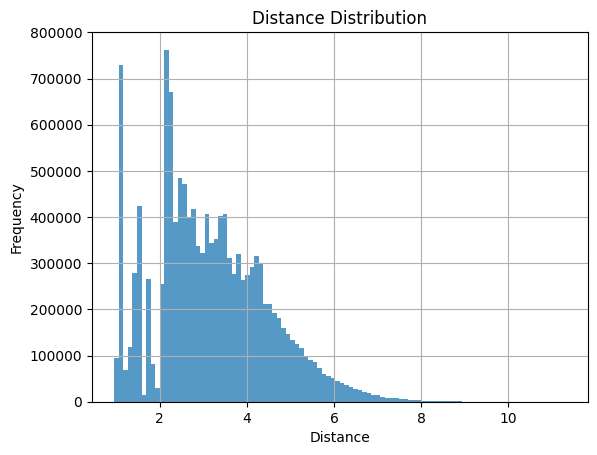

In [19]:
import matplotlib.pyplot as plt
array = edge_weight.numpy()
plt.hist(array, bins=100, alpha=0.75)
plt.title('Distance Distribution')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()